# Sample notebook for Iris dataset


## Setup

Download the dataset from the [iris kaggle competition](https://www.kaggle.com/uciml/iris).
Place the *csv* file it in a directory called *data* with the name *Iris.csv*.

## Libraries

If `install.sh` ran successfully, you should have all the required libraries:

* `numpy` - Library for fast C++ arrays/matrix and operations on those.
* `pandas` - Library for loading & processing & writing csv/json/etc. as matrixes.
* `scikit-learn` - Library for machine learning algorithms. Mostly compatible with numpy & pandas.
* `matplotlib` - Library for plots.
* `seaborn` - Library for high level plots that uses `matplotlib` under the hood.


In [1]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

## Data loading and statistics

Here the data is loaded and cleaned (The `Id` column is removed). Afterwards the first samples are shown and some statistics are computed by the `describe` method.

In [2]:
iris_data = pd.read_csv('../data/Iris.csv')
data = iris_data.drop(columns='Id')

In [3]:
iris_data.head(3)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa


In [4]:
data.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Further preprocessing

The labels need to be numbers for the `scikit-learn` algorithms. Also, here we divide the dataset into train/test set. If you need a validation set also, split the training set further.

In [5]:
data[data['Species'] == 'Iris-setosa'] = 0
data[data['Species'] == 'Iris-virginica'] = 1
data[data['Species'] == 'Iris-versicolor'] = 2

labels = data['Species']
data = data.drop(columns='Species')

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, shuffle=True, test_size=0.33)

## Plots

As all the features are continious, we can plot the distribution for each of the features.


There is something pelicular about the distribution (The blue line). Let's take a closer look at the regularities.


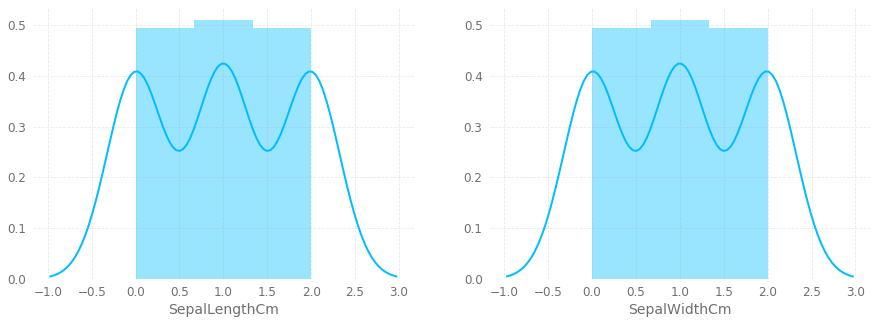

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sbn.distplot(train_data['SepalLengthCm'], ax=axes[0])
sbn.distplot(train_data['SepalWidthCm'], ax=axes[1])

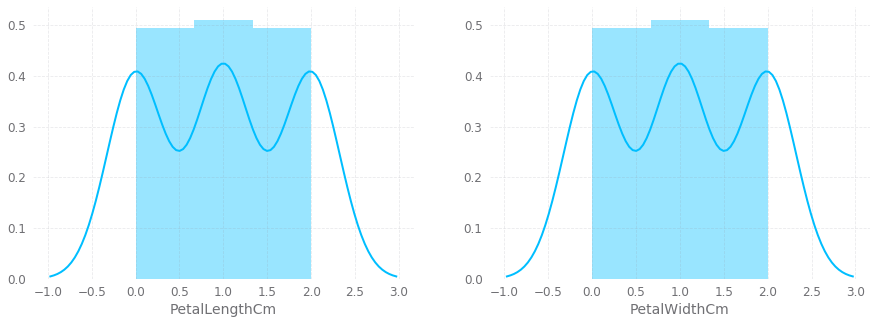

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sbn.distplot(train_data['PetalLengthCm'], ax=axes[0])
sbn.distplot(train_data['PetalWidthCm'], ax=axes[1])

We can observe that each plot has 3 peaks.

If we consider a normal distribution at each peak, then we can build the whole distribution with 3 normal/gaussian distributions. We can conclude that each gaussian is generated by one label (There are 3 labels).

## Clusterization

In this example, I use the `EM` algorithm for clustering. My goal is to see if we can separate instances without knowing without knowing the labels.

`EM` as an algorithm works like `KMeans`. We choose a *K* which is the number of clusters and some initial clusters. For EM, clusters are more complex as they are gaussian/normal distributions. As such they have a center $\mu_c$, a standard deviation $\sigma_c$, and also a probability of selection $\pi_c$.

Let there be $N$ instances. Let there be an arbitrary instance $x_i$ and a cluster $c$ defined by $(\mu_c, \sigma_c, \pi_c)$. Then:


Probability of the $x_i$ to be in cluster $c$ -> $P(x_i | C=c) = P(x_i | \mu_c ; \sigma_c) \overset{remember \ from \ normal \ dist}{=} \frac{1}{\sigma_c \cdot \sqrt{2 \pi}} \cdot e^{-\frac{(x_i - \mu_c)^2}{2 \cdot \sigma_c^2}}$

Prior probability of selecting the cluster $c$ -> $P(C=c) = \pi_c$


Using these formulas and a loss function, as in `KMeans`, we assign the instances to clusters (based on the highest probability this time) and then recompute $\mu_c, \sigma_c, \pi_c$ for each cluster. We repet this until the loss function of the `EM` does not change (or the change is small).

`EM` steps:
* Choose a *K* which will be the number of clusters
* Iterate until the asignation does not change
 * For each instance i and cluster c, we compute a variable called $Z_{ic} = P(C=c) \cdot P(x_i | C=c)$
 * Assignation: For each instance i, we assign it to the most likely cluster - $\underset{c}{argmax}\ Z_{ic}$
 * Recomputation:
   * The new cluster center $\mu_{c} = \frac{\sum_{i=1}^{N} Z_{ic} \cdot x_i}{\sum_{i=1}^{N} Z_{ic}}$
   * The new standard deviation $\sigma_{c} = \frac{\sum_{i=1}^{N} Z_{ic} \cdot (x_i - \mu_{c})^2}{\sum_{i=1}^{N} Z_{ic}}$
   * The new cluster probability $\pi_c = \frac{\sum_{i=1}^{N} Z_{ic}}{N}$

`EM` is more robust than `KMeans` as the clusters are probabilistic and can assume more diverse shapes. Also all the points in the dataset affect the cluster centers based on their distance from the center (the further they are, the smaller $P(x_i | C=c)$ becomes).

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
em = GaussianMixture(n_components=3) # 3 clusters
em.fit(train_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
clusters = em.predict(test_data)

## Testing

We check to see how many instances I managed to separate. The `completeness_score` is a method that checks to see how well the clustering algorithm managed to separate the instances by comparing the clusters with the actual labels. For more information check [this](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html).

In [12]:
from sklearn.metrics import completeness_score

score = completeness_score(test_labels, clusters)
print('Score:', score)

Score: 1.0


The score is one or close to one. We managed to separate everything perfectly.

## Classification

Sample classification using some classifier. In this case, I used a classifier called `SVM` to show an example of how `scikit-learn` api works.

In [13]:
from sklearn.svm import SVC

In [14]:
classifier = SVC()

In [15]:
classifier.fit(train_data, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [16]:
predicted_test_labels = classifier.predict(test_data)

In [17]:
from sklearn.metrics import accuracy_score

score = accuracy_score(test_labels, predicted_test_labels)
print('Accuracy:', score)

Accuracy: 1.0


Everything was classified perfectly. Do not expect this to happen for your dataset (this is a easy toy dataset, in real life expect much lower results).

Depending on you dataset, accuracy may be a poor choice. For example, think of some disease in medicine where 95% of the patients are healthy and 5% are sick. If we use a classifier that always predicts that the patients are healthy, then the accuracy we have is 95%, which is very high. For this kind of problem, we have to consider other metrics that may be more relevant. For you problem, choose your metrics carefully. List of metrics to use:

* [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
* [Confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
* [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
* [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
* [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
* [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)